In [1]:
import numpy as np
from smpl import plot
from smpl import functions as fff
import scipy

In [2]:

from scipy.misc import derivative

def trim_domain(f,    
    fmin = np.finfo(np.float32).min/2,
    fmax = np.finfo(np.float32).max/2,
    steps=100000,
    min_ch=0.001
               ):
    test = np.linspace(fmin,fmax,steps)
    dr = derivative(f,test,dx=1e-06)
    m1 = np.abs(dr)>min_ch
    bmin=np.argmax(m1)
    m2=(np.abs(dr)>min_ch)[::-1]
    tbmax=np.argmax(m2)
    xmin = test[bmin]
    xmax=test[::-1][tbmax]
    if bmin == 0 and tbmax ==0 and not m1[0] and not m2[0]:
        # trisect
        tmin = xmin
        tmax = xmax
        t1a,t1b = trim_domain(f,tmin+ (tmax-tmin)/3,tmax -(tmax-tmin)/3,min_ch=min_ch)
        if np.isclose(t1a,t1b):
            t2a,t2b = trim_domain(f,tmin + (tmax-tmin)/3,tmax,min_ch=min_ch)
            if np.isclose(t2a,t2b):
                t3a,t3b = trim_domain(f,tmin ,tmax- (tmax-tmin)/3,min_ch=min_ch)
                if np.isclose(t3a,t3b):
                    return 0.,0. 
                else:
                    return t3a,t3b    
            else:
                return t2a,t2b
        else:
            return t1a,t1b
    return xmin,xmax
 
def get_domain(f,
    fmin = np.finfo(np.float32).min/2,
    fmax = np.finfo(np.float32).max/2,
    steps=100000,
):
    """
    Return the domain of the function ``f``.
    """
    
    test = np.linspace(fmin,fmax,steps)
    
    r = f(test)
    mask = np.isfinite(r)        
    tr = test[mask]
    if len(tr)>0:
        tmin = np.amin(tr)
        tmax = np.amax(tr)
        test_r = np.linspace(tmin,tmax,steps)
        if np.equal(tr.shape , test_r.shape) and np.allclose(test_r,tr):
            return tmin,tmax
    
    # trisect
    tmin = fmin
    tmax = fmax
    t1a,t1b = get_domain(f,tmin+ (tmax-tmin)/3,tmax -(tmax-tmin)/3)
    if np.isclose(t1a,t1b):
        t2a,t2b = get_domain(f,tmin + (tmax-tmin)/3,tmax)
        if np.isclose(t2a,t2b):
            t3a,t3b = get_domain(f,tmin ,tmax- (tmax-tmin)/3)
            if np.isclose(t3a,t3b):
                return 0.,0. 
            else:
                return t3a,t3b    
        else:
            return t2a,t2b
    else:
        return t1a,t1b

In [3]:
def is_monotone(f,tmin=None,tmax=None,):
    """
    Test if function ``f`` is monotone.

    Parameters
    ----------
    f : function
        Function to be tested.
    test : array_like
        Test points.

    Returns
    -------
    bool
        True if function is monotone.
    """
    if tmax is None and tmin is None:
        tmin,tmax = get_domain(f)
    test = np.linspace(tmin,tmax,1000)
    return np.all(f(test[1:])>=f(test[:-1]))

In [4]:
def get_interesting_region(f,min_ch = 1e-4):
    """
    Return interesting xmin and xmax of function ``f``.
    """
    omin_x,omax_x = get_domain(f)
    if is_monotone(f,omin_x,omax_x):
        min_x,max_x=trim_domain(f,omin_x,omax_x,min_ch = min_ch)
        #min_x,max_x=omin_x,omax_x
    else:
        tmax_x= scipy.optimize.minimize(lambda x: -f(x),0.,method='Nelder-Mead',bounds=[(omin_x,omax_x)])
        tmin_x= scipy.optimize.minimize(f,0.,method='Nelder-Mead',bounds=[(omin_x,omax_x)])
        if tmax_x.success:
            tmax_x = tmax_x.x[0]
        else:
            tmax_x =0.
        if tmin_x.success:
            tmin_x = tmin_x.x[0]
        else:
            tmin_x =0.
        
        if abs(tmax_x) > np.finfo(np.float32).max/10:
            tmax_x = 0.
        if abs(tmin_x) > np.finfo(np.float32).max/10:
            tmin_x = 0.
        x_min = min(tmax_x,tmin_x)
        x_max = max(tmax_x,tmin_x)
        min_x = ((x_max+x_min)/2-(x_max-x_min))
        max_x = ((x_max+x_min)/2+(x_max-x_min))
        if np.isclose(min_x,max_x):
            min_x,max_x=trim_domain(f,omin_x,omax_x,min_ch = min_ch)
            
    print(min_x,max_x)        
    return min_x,max_x

In [5]:
f = np.exp
print(np.finfo(np.float64).min,np.finfo(np.float64).max)
print(get_domain(f))
print(np.isclose(*get_domain(f)))
print(is_monotone(f))

-1.7976931348623157e+308 1.7976931348623157e+308
(-279.714718534727, 279.714718534727)


/tmp/ipykernel_24996/2162550493.py:47: RuntimeWarning: overflow encountered in exp
  r = f(test)


False
True


/tmp/ipykernel_24996/2086393400.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


-9.205503442012287 279.714718534727


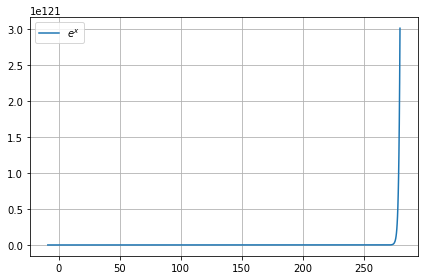

In [6]:
def ff(x):
    return np.exp(x)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-3.141625000000003 3.141625000000003


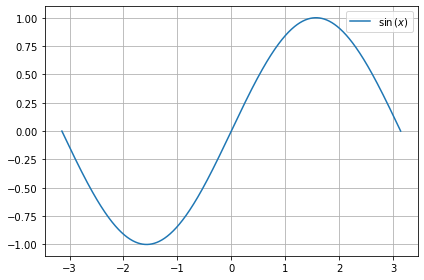

In [7]:
def ff(x):
    return np.sin(x)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-7110043947.625 7110043947.625


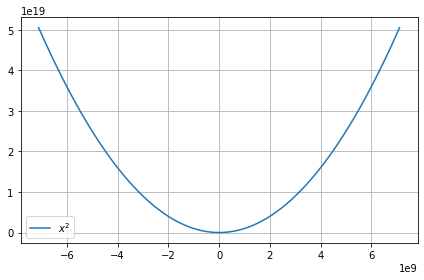

In [8]:
def ff(x):
    return x**2
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-7110043947.625 7110043947.625


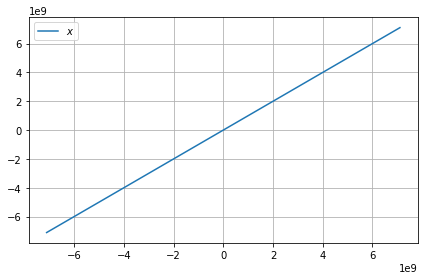

In [9]:
def ff(x):
    return x
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-1.5707812500000022 4.712343750000007


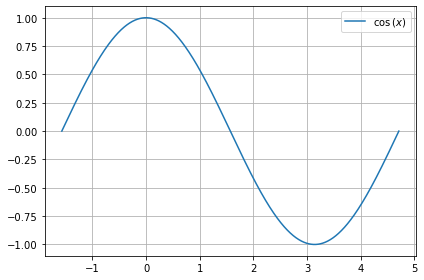

In [10]:
def ff(x):
    return np.cos(x)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-55.056798617355525 55.056798617355525


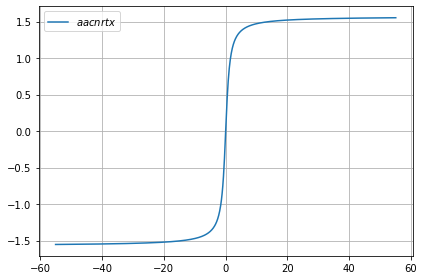

In [11]:
def ff(x):
    return np.arctan(x)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-3.141592653589793 3.141592653589793


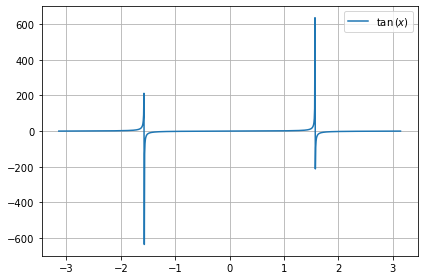

In [12]:
def ff(x):
    return np.tan(x)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

-18.352266205940396 18.352266205707565


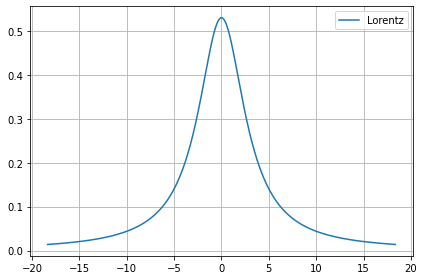

In [13]:
def ff(x):
    """Lorentz"""
    return fff.lorentz(x,0,5,3,0)
xmin,xmax =get_interesting_region(ff)
plot.function(ff,xmin=xmin,xmax = xmax,logy=False)

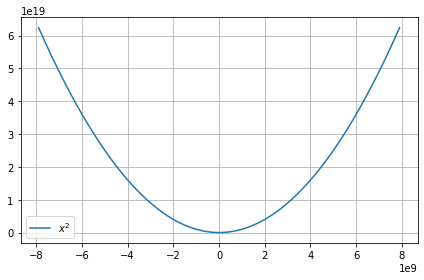

In [14]:
from smpl import plot
plot.function(lambda x: x**2,)

/tmp/ipykernel_24996/2310528.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(x)


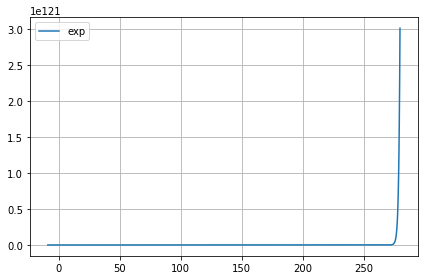

In [15]:
from smpl import plot
def f(x):
    return np.exp(x)
plot.function(f,label="exp")

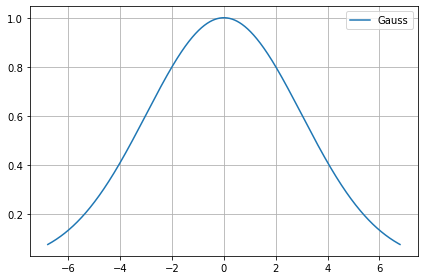

In [16]:
from smpl import plot
from smpl import functions as f
def gauss(x):
    """Gauss"""
    return f.gauss(x,0,1,3,0)
plot.function(gauss)